In [1]:
# # !!! only uncomment and run when using colab !!!
# import os
# ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
# os.chdir("/content/CPlantBox/")
# ! git pull
# ! cmake .
# ! make
# os.chdir("/content/CPlantBox/tutorial/jupyter/UQ_15_08_2022/")

# UQ presentation - 2022

In [9]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
import vtk_plot as vp # for quick 3d vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np

## 1. Simulate a plant

In [23]:
# Create instance describing a plant
plant = pb.Plant()

# Open plant parameter from a file
path = "../../../modelparameter/plant/"
name = "0"#
plant.readParameters(path + name + ".xml")

# define 2D shape
for p in plant.getOrganRandomParameter(pb.leaf):
    p.a = 0.05
    p.a_s = 0
    if (p.subType > 0): 
        #print(p.subType, "radius", p.a, "lmax", p.lmax, p.ln, p.lb, p.successor, p.nob())        
        if (p.subType > 2): 
            
            #Round leaf:
            if False:
                p.lb =  1 # length of leaf stem
                p.la,  p.lmax = 5, 11
                p.areaMax = 3.145*(((p.lmax-p.la - p.lb)/2)**2)
                phi = np.array([-90, -45, 0., 45,67.5,70, 90]) / 180. * np.pi
                l_ = (p.lmax - p.lb - p.la)/2
                l = np.array([l_ for x_i in range(len(phi))]) 

            #flower-shaped leaf:
            if False:
                p.areaMax = 100 
                p.la, p.lb, p.lmax = 5, 1, 11
                phi = np.array([-90., -67.5, -45, -22.5, 0, 22.5, 45, 67.5, 90]) / 180. * np.pi
                l = np.array([5., 1, 5, 1, 5, 1, 5, 1, 5])
                
            #small leaf
            if True:
                p.la, p.lb, p.lmax, p.ln, = 3.5, 1., 7.5, 3  
                p.areaMax = 10  # cm2
                phi = np.array([-90, -45, 0., 45, 90]) / 180. * np.pi
                l= np.array([3, 2.2, 1.7, 2, 3.5])
            
            
            N = 101  # N is rather high for testing
            p.createLeafRadialGeometry(phi, l, N)
            p.parametrisationType = 0
            p.tropismT = 1
            p.tropismN = 5
            p.tropismS = 0.1
   
        else:
            p.a = p.a * 3

# Simulate
plant.initialize() 
plant.simulate(30) # [days]

# Export
plant.write("first_example.vtp") # for Paraview
plant.write("first_example.rsml") # e.g. gui/viewer/rsml_viewer.py

# Visualize
_ = vp.plot_plant(plant,"creationTime") # Plot, using vtk (e.g. "subType")

Seed::initialize: Plant 
Could not respect geometry boundaries 
Organism::readParameters: plant tag was not found in xml file, retrying with Plant 
LeafRandomParameter::createLeafRadialGeometry: Warning! parametrisation vectors y and l are empty or differ in size
for leaf subType 3, leafGeometry.size() is 100
for leaf subType 3, leafGeometry.size() is 101
Seed::initialize: Plant 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


## 2. Post-processing (how to evaluate simulation results)

Basically, there are two methods 

1. Using class *Plant* directly, parameter values are given per root (root system is represented as polylines).

2. Using class *SegmentAnalyser*, which will consider all segments of the root system, parameter values are given per segment (root system is represented by nodes and segments).

### 2.1 Root system length vs time

The following example will plot length versus time for the root system, and each subType (see *example2d_length.py*)

writing VTP... first_example.vtp
writing RSML... first_example.rsml
Organism::readParameters: plant tag was not found in xml file, retrying with Plant 
LeafRandomParameter::createLeafRadialGeometry: Warning! parametrisation vectors y and l are empty or differ in size
for leaf subType 3, leafGeometry.size() is 100
Seed::initialize: Plant 
Seed::initialize: Basal root type #4 was not defined, using tap root parameters instead


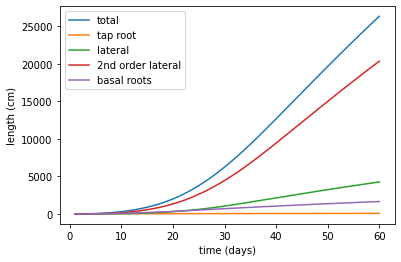

final tap root length:  77.90987955075941 cm


In [24]:
rs = pb.Plant()
path = "../../../modelparameter/plant/"
name = "0"#"Zea_mays_1_Leitner_2010"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize() # reset above simulation
scalar_type = "length" # "surface", "volume"
simtime = 60.  # final simulation time [day]
dt = 1. # time step [day]
N = round(simtime / dt)  # number of iterations
v_, v1_, v2_, v3_, v4_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
""" Simulation loop """
for i in range(0, N):
    rs.simulate(dt)
    ot = np.array(rs.getParameter("organType")) # take only root
    t = np.array(rs.getParameter("subType")) # value per root subtype
    v = np.array(rs.getParameter(scalar_type)) # all random or specific parameters are accessible
    v_[i] = np.sum(v[ot==2])
    v1_[i] = np.sum(v[np.logical_and(t == 1, ot == 2) ])
    v2_[i] = np.sum(v[np.logical_and(t == 2, ot == 2)])
    v3_[i] = np.sum(v[np.logical_and(t == 3, ot == 2)])
    v4_[i] = np.sum(v[np.logical_and(t == 4, ot == 2)])
    
t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_, t_, v4_)
plt.xlabel("time (days)")
plt.ylabel(scalar_type + " (cm)")
plt.legend(["total", "tap root", "lateral", "2nd order lateral", "basal roots"])
# plt.savefig("myplot.png") # we could save it as png
plt.show()
print("final tap root length: ", v1_[-1], "cm")

## 2.2 Analyse results from the class *SegmentAnalyser* (values per segment) in a loop

The main functionality of the *SegmentAnalyser* class is:
* *getParameter(name)* as for *RootSystem* class, but returning a value for each segment, especially the "creationTime" of each segment
* *filter(name, min, max)* will keep only segments where the value of parameter *name* is within [min, max]
* *crop(sdf)* will keep only segments inside a geometry (e.g. in a soil core), segments intersecting the domain boundary are cut. 
* *distribution(...)* will create a 1d plot versus depth, where parameters are summed in layers 
* *distribution2d(...)* as above but 2d
* *mapPeriodic(length, width)* maps the unconstrained root system into a periodic domain
* *addData(name, data)* attach user data to the segments (e.g. simulation results for visualization or export)

Note that *SegmentAnalyser* is only loosly connected to the original simulation.

The first example shows how to obtain a depth distribution (values per segment) in a simulation loop.

Could not respect geometry boundaries 
Organism::readParameters: plant tag was not found in xml file, retrying with Plant 
LeafRandomParameter::createLeafRadialGeometry: Warning! parametrisation vectors y and l are empty or differ in size
for leaf subType 3, leafGeometry.size() is 100


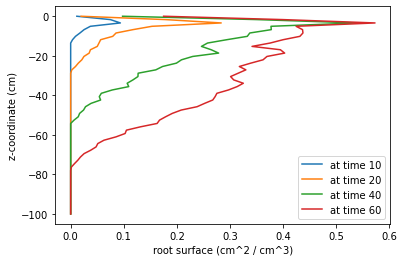

In [25]:
s = pb.Plant()
path = "../../../modelparameter/plant/"
name = "0"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

simtimes = [0,10,20,40,60] # day
dt_ = np.diff(simtimes) # day
depth = 100 # cm
layers = 60 # [1]

""" Simulation loop """
rsd_ = []
for dt in dt_:    
    rs.simulate(dt)
    #_ = vp.plot_plant(rs, "subType") # to observe growth
    ana = pb.SegmentAnalyser(rs) # create a SegmentAnalyser object
    rsd = ana.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd) # store relevant data in a list

""" vizualize rld_ """
soilvolume = (depth / layers) * 10 * 10
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]

z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, label = "at time "+str(t))

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()
#_ = vp.plot_plant(rs, "subType") # final result